# Analysis of dataSet6

Instances consist of 3 feature: $a$, $b$, $c$. The goal is to define clusters and develop a predicitve model for these clusters.

In [1]:
### Import packages for data analysis
import os    # OS module provides the interface with the operating system and allows to use it
import tarfile
from six.moves import urllib
import pandas as pd     # Pandas: python library for large data manipulation and analysis. 
                        # Dataset will be saved as Pands dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings("ignore")


### Acquire dataset
data_path='C:/Users/jacopo/Desktop/schaeffler/testData6.csv'
dataset = pd.read_csv(data_path,sep=';')   # dataset as pandas dataset


## Part 1: Visualization and descriptive statistics of the dataset

The goal of this analysis is to get some insights on the data and eventually spot the presence of clusters. 

The dataset consists of 5000 instances with **numerical continuous features**. 

The dataset is also **complete**, no NaN were found. 

Features have the **same order of magnitude**. Means and standard deviation are close to each others.

In [2]:
print('Overview of the dataset: size of dataset and type of data:\n')
dataset.info()

print('\nDescriptive statistics of the dataset:')
dataset.describe()

Overview of the dataset: size of dataset and type of data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
a    5000 non-null float64
b    5000 non-null float64
c    5000 non-null float64
dtypes: float64(3)
memory usage: 117.3 KB

Descriptive statistics of the dataset:


,a,b,c
count,5000.000000,5000.000000,5000.000000
mean,-165.730680,-173.661186,-151.365124
std,4196.018485,4168.445734,4289.631511
min,-7902.340000,-7585.190000,-8330.840000
25%,-2923.310000,-2943.562500,-3347.752500
50%,-3.675000,-3.060000,68.615000
75%,3269.232500,3025.977500,3012.525000
max,6861.640000,7511.560000,10229.370000


(-11000, 13000)

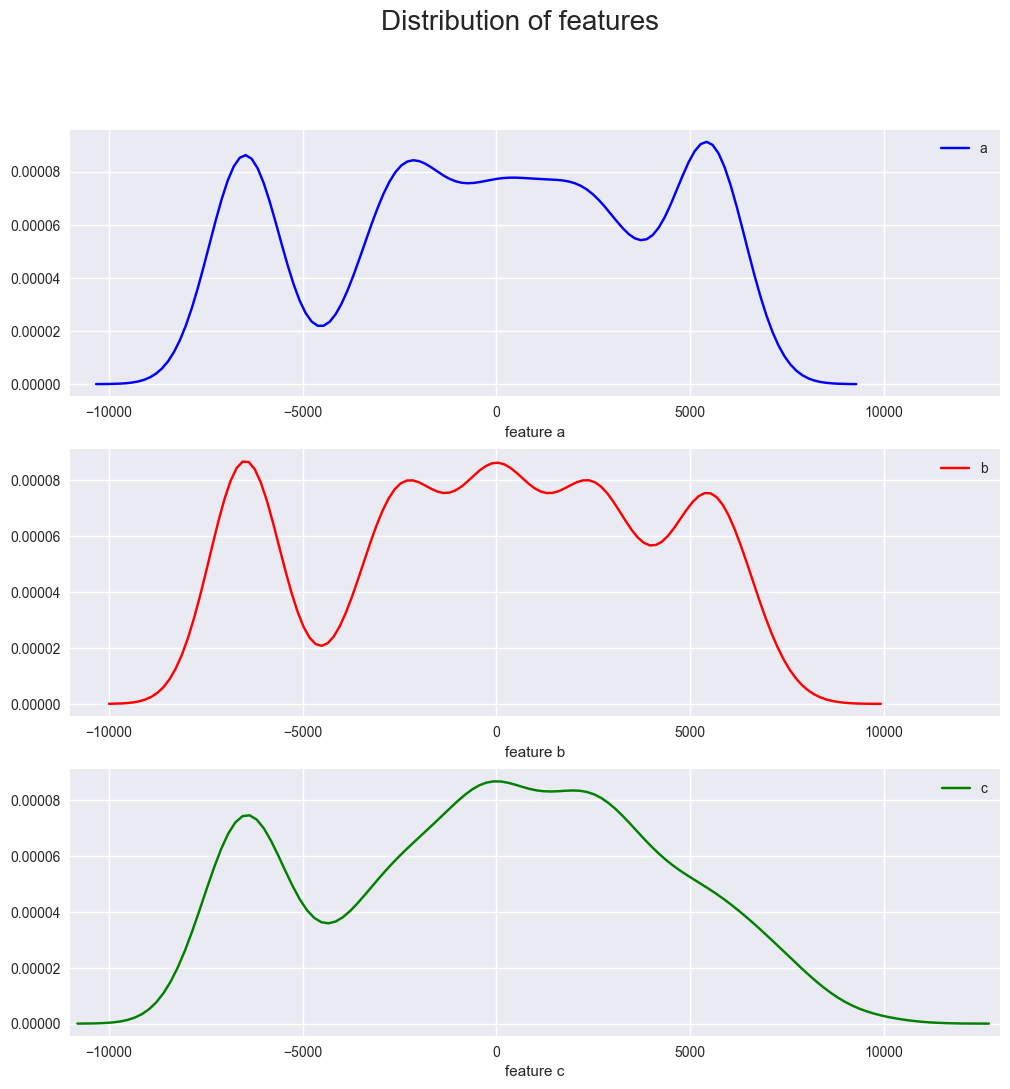

In [3]:
# Create a figure instance, and the two subplots

x_range = [-11000, 13000]

fig = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
fig.suptitle('Distribution of features',fontsize=20)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


# Plot distribution of feature a
sns.kdeplot(dataset['a'],color='b', ax = ax1)
ax1.set_xlabel('feature a')
ax1.set_xlim(x_range)

# Plot distribution of feature b
sns.kdeplot(dataset['b'],color='r', ax = ax2)
ax2.set_xlabel('feature b')
ax2.set_xlim(x_range)

# Plot distribution of feature c
sns.kdeplot(dataset['c'],color='g', ax = ax3)
ax3.set_xlabel('feature c')
ax3.set_xlim(x_range)



From the analysis of the distributions, we can clearly distinguish **peaks in the distribution curves** of the features. This indicates the **presence of clusters**. 

In particular, it is possible to distinguish two peaks for $c$ (bimodal distribution) and two peaks plus a flat peak central region for the features $a$, and five peaks for $b$. Notably for the feature $b$, the central region presents 3 small peaks. Therefore, the presence of these peaks confirm the presence of clusters of data. Since two distributions present three clear 'peaks', it is reasonable to expect *three to five clusters*. 

Since we have three features, we can generate 3D scatter plots. 

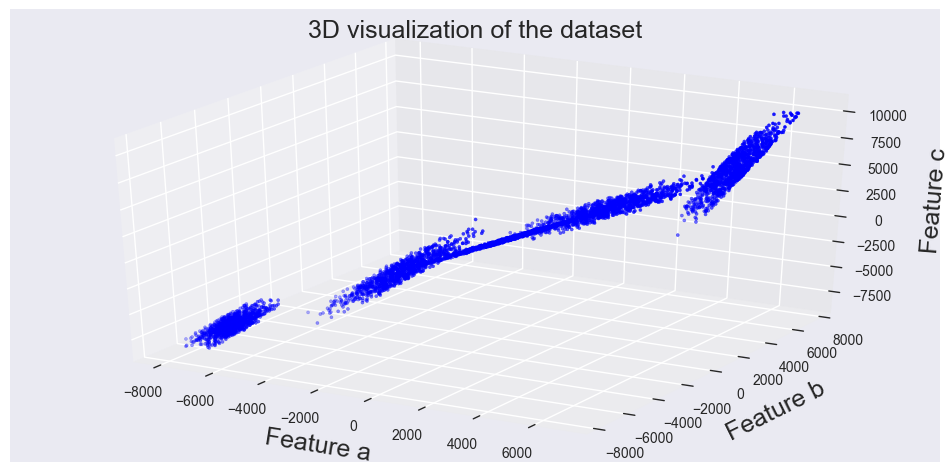

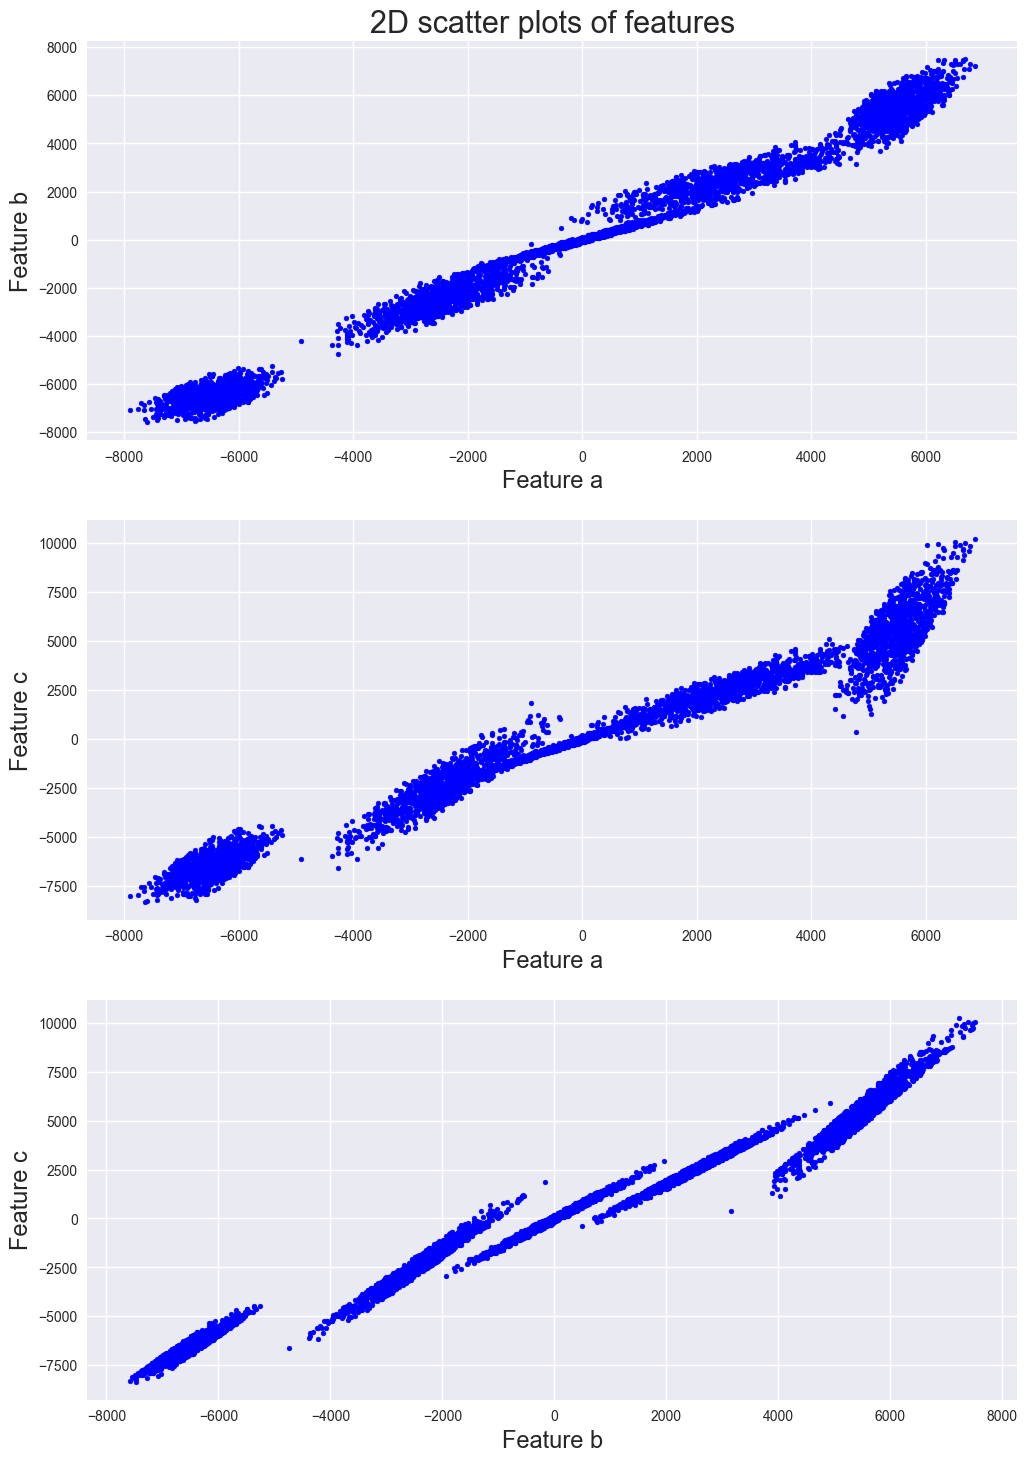

In [4]:
# 3D plot
fig = plt.figure(num=None, figsize=(12, 6), dpi=100,facecolor='w',edgecolor='k')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset['a'],dataset['b'],dataset['c'], c='b', marker='.')

ax.set_xlabel('Feature a',fontsize=18,labelpad=15)
ax.set_ylabel('Feature b',fontsize=18,labelpad=15)
ax.set_zlabel('Feature c',fontsize=18,labelpad=15)

plt.title('3D visualization of the dataset',fontsize=18)

plt.show()



# 2D scatterplot of features
fontS = 17
f, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False, sharey=False, dpi=100, facecolor='w', edgecolor='k')

# Plot 1: a-b
axes[0].scatter(dataset['a'],dataset['b'], c='b', marker='.')
axes[0].set_xlabel('Feature a',fontsize=fontS)
axes[0].set_ylabel('Feature b',fontsize=fontS)
axes[0].set_title('2D scatter plots of features',fontsize=22)

# Plot 2: a-c
axes[1].scatter(dataset['a'],dataset['c'], c='b', marker='.')
axes[1].set_xlabel('Feature a',fontsize=fontS)
axes[1].set_ylabel('Feature c',fontsize=fontS)

# Plot 3: b-c
axes[2].scatter(dataset['b'],dataset['c'], c='b', marker='.')
axes[2].set_xlabel('Feature b',fontsize=fontS)
axes[2].set_ylabel('Feature c',fontsize=fontS)

plt.show()

From the previous scatter plots it is possible to observe three clear clusters of data (3D plot). However, from the plot $(b,c)$, we can clearly distinguish **5 clusters of data**. 

In addition, it is possible to observe that data are distributed along a specific direction (diagonal of each scatter plot), which is the direction of maximum variance. Therefore, we analyze the principal components of these data using PCA.

variance along the principal axes:
[ 0.99329497  0.00528323]


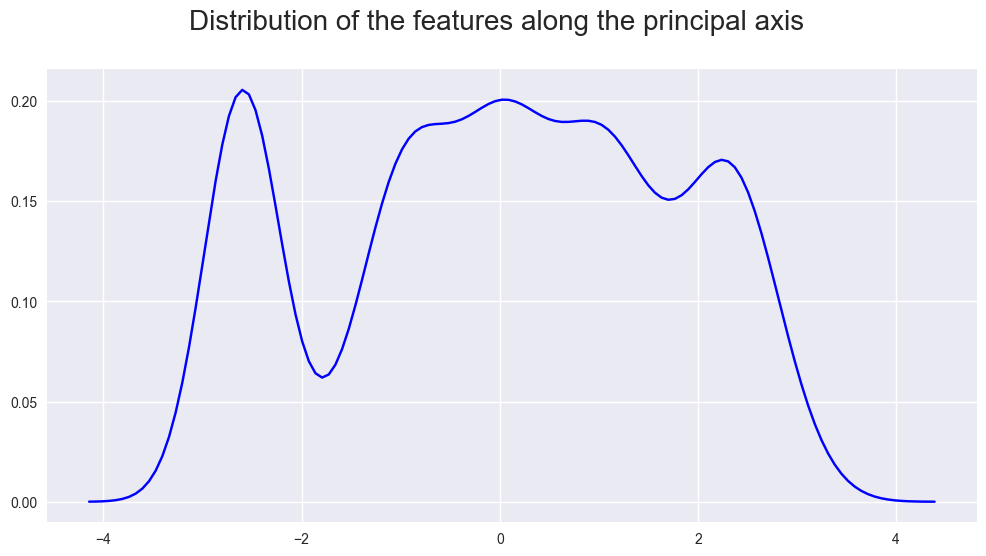

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataset_std = StandardScaler().fit_transform(dataset)
pca = PCA(n_components = 2).fit(dataset_std)

print('variance along the principal axes:')
print(pca.explained_variance_ratio_)

data_transformed = pca.transform(dataset_std)

# Plot distribution of transformed data
fig = plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
fig.suptitle('Distribution of the features along the principal axis',fontsize=20)

sns.kdeplot(data_transformed[:,0],color='b')


The Principal Component Analysis shows that the distribution of features on the principal axis presents on clear peak at about -11000, a second peak at around 0 and a third peak at around 10000. This analysis confirms the **presence of three to five clusters of data**. It is necessary to remember that when data are projected on the principal axis, some information are lost (loss proportional to the distance to the principal axis). Therefore, the third peak at 10000 may be more distinguished as in the 2D scatter plots previously described.

## Part 2: Data clustering via DBSCAN

We now apply DBSCAN to cluster data. The reason of this choice is that we have observed the **presence of 3 to 5 clusters, which do not have spherical shape**. 

To cluster data, all the three features $a$, $b$, $c$ are used since the nature of such features is unknown. Usually, clusters can be detected by using specific features only like ($b$,$c$). However, this procedure is possible when nature of data is known.

Even if we could use ($b$,$c$) to define the 5 clusters, we use all the features and then we analyze the silhouette parameter.

In [6]:
# Function for plotting distribution of features in each cluster

def distribution_features_cluster(C_1,C_2,C_3,C_4,C_5,out):
    fig = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    # Plot distribution of feature a
    attr = 0
    sns.kdeplot(C_1[attr],label="C_1",color='b', ax = ax1)
    sns.kdeplot(C_2[attr],label="C_2",color='r', ax = ax1)
    if np.shape(C_3)[0]>0:
        sns.kdeplot(C_3[attr],label="C_3",color='g', ax = ax1)
    if np.shape(C_4)[0]>0:
        sns.kdeplot(C_4[attr],label="C_4",color='y', ax = ax1)
    if np.shape(C_5)[0]>0:
        sns.kdeplot(C_5[attr],label="C_5",color='k', ax = ax1)
    ax1.set_title('feature a')




    # Plot distribution of feature b
    attr = 1
    sns.kdeplot(C_1[attr],label="C_1",color='b', ax = ax2)
    sns.kdeplot(C_2[attr],label="C_2",color='r', ax = ax2)
    if np.shape(C_3)[0]>0:
        sns.kdeplot(C_3[attr],label="C_3",color='g', ax = ax2)
    if np.shape(C_4)[0]>0:
        sns.kdeplot(C_4[attr],label="C_4",color='y', ax = ax2)
    if np.shape(C_5)[0]>0:
        sns.kdeplot(C_5[attr],label="C_5",color='k', ax = ax2)
    ax2.set_title('feature b')



    # Plot distribution of feature c
    attr = 2
    sns.kdeplot(C_1[attr],label="C_1",color='b', ax = ax3)
    sns.kdeplot(C_2[attr],label="C_2",color='r', ax = ax3)
    if np.shape(C_3)[0]>0:
        sns.kdeplot(C_3[attr],label="C_3",color='g', ax = ax3)
    if np.shape(C_4)[0]>0:
        sns.kdeplot(C_4[attr],label="C_4",color='y', ax = ax3)
    if np.shape(C_5)[0]>0:
        sns.kdeplot(C_5[attr],label="C_5",color='k', ax = ax3)
    ax3.set_title('feature c')


    plt.show()
    

    # Labeled 3D plot
    fig = plt.figure(num=None, figsize=(12, 6), dpi=100,facecolor='w',edgecolor='k')

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(C_1[:,0],C_1[:,1],C_1[:,2], c='b', marker='.',label="C_1")
    ax.scatter(C_2[:,0],C_2[:,1],C_2[:,2], c='r', marker='.',label="C_2")
    ax.scatter(C_3[:,0],C_3[:,1],C_3[:,2], c='g', marker='.',label="C_3")
    ax.scatter(C_4[:,0],C_4[:,1],C_4[:,2], c='y', marker='.',label="C_4")
    ax.scatter(C_5[:,0],C_5[:,1],C_5[:,2], c='k', marker='.',label="C_5")
    ax.scatter(out[:,0],out[:,1],out[:,2], c='w', marker='d',label="outl.")

    ax.set_xlabel('Feature a',fontsize=18,labelpad=15)
    ax.set_ylabel('Feature b',fontsize=18,labelpad=15)
    ax.set_zlabel('Feature c',fontsize=18,labelpad=15)

    plt.title('3D visualization of clustered data',fontsize=18)
    plt.legend()

    plt.show()

Before applying DBSCAN, we scale the features using scikit-learn's Min-Max scaler

In [7]:
# scaling of data before using DBSCAN
from sklearn.preprocessing import MinMaxScaler

scaler_Feature = MinMaxScaler().fit(dataset)

dataset_scaled = scaler_Feature.transform(dataset)
A_scaled = dataset_scaled[:,0]
B_scaled = dataset_scaled[:,1]
C_scaled = dataset_scaled[:,2]

DBSCAN has three important hyperparameters:
1. eps: maximum distance from a core point

2. minP: minimum number of points that define a cluster

3. Definition of how to compute distance between points

We now run DBSCAN for several values of $eps$ and we compute the silhouette.


In [24]:
# Application of DBscan with eps = 0.022
from sklearn.cluster import DBSCAN
from sklearn.metrics import *

def run_DB(eps_input):
    db = DBSCAN(eps=eps_input, 
                min_samples=5, 
                metric='euclidean', 
                algorithm='auto', 
                p=None, 
                n_jobs=1)

    db.fit(dataset_scaled)
    labels = db.labels_   # each element is assigned to a number according to the cluster 

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)



    # Get clusters: create a new numpy array for each cluster
    C1= dataset_scaled[np.where(labels == 0)]
    C2 = dataset_scaled[np.where(labels == 1)]
    C3 = dataset_scaled[np.where(labels == 2)]
    C4 = dataset_scaled[np.where(labels == 3)]
    C5 = dataset_scaled[np.where(labels == 4)]
    C6 = dataset_scaled[np.where(labels == 5)]
    C7 = dataset_scaled[np.where(labels == 6)]
    outL = dataset_scaled[np.where(labels == -1)]

    

    # compute silhouette
    # Cluster: 1
    N1 = np.shape(C1)[0]
    data_cluster_1 = np.ones((N1,4))*0
    data_cluster_1[:,:-1] = C1

    # Cluster: 2
    N2 = np.shape(C2)[0]
    data_cluster_2 = np.ones((N2,4))*1
    data_cluster_2[:,:-1] = C2

    # Cluster: 3
    N3 = np.shape(C3)[0]
    data_cluster_3 = np.ones((N3,4))*2
    data_cluster_3[:,:-1] = C3

    # Cluster: 4
    N4 = np.shape(C4)[0]
    data_cluster_4 = np.ones((N4,4))*3
    data_cluster_4[:,:-1] = C4

    # Cluster: 5
    N5 = np.shape(C5)[0]
    data_cluster_5 = np.ones((N5,4))*4
    data_cluster_5[:,:-1] = C5

    # Cluster: 6
    N6 = np.shape(C6)[0]
    data_cluster_6 = np.ones((N6,4))*5
    data_cluster_6[:,:-1] = C6

    # Cluster: 7
    N7 = np.shape(C7)[0]
    data_cluster_7 = np.ones((N7,4))*4
    data_cluster_7[:,:-1] = C7


    # labeled dataset
    dataset_labeled = np.concatenate((data_cluster_1,data_cluster_2,data_cluster_3,
                                         data_cluster_4,data_cluster_5,data_cluster_6,data_cluster_7),axis=0)


    silh = silhouette_score(dataset_labeled[:,0:3],dataset_labeled[:,3])
    
    
    # print result
    print('DBSCAN with EPS = ' + str(eps_input))
    print('Number of clusters: ' + str(n_clusters_))
    print('Number of outliers (points not assigned to a cluster): '+ str(len(outL)))
    print('Average silhouette score: ' + str(silh) + '\n')


In [30]:
# cluster points
run_DB(0.022)

run_DB(0.025)

run_DB(0.026)

run_DB(0.028)

run_DB(0.03)

run_DB(0.05)

DBSCAN with EPS = 0.022
Number of clusters: 7
Number of outliers (points not assigned to a cluster): 25
Average silhouette score: 0.536025720925

DBSCAN with EPS = 0.025
Number of clusters: 6
Number of outliers (points not assigned to a cluster): 14
Average silhouette score: 0.441402097323

DBSCAN with EPS = 0.026
Number of clusters: 5
Number of outliers (points not assigned to a cluster): 11
Average silhouette score: 0.567620738383

DBSCAN with EPS = 0.028
Number of clusters: 4
Number of outliers (points not assigned to a cluster): 9
Average silhouette score: 0.559807483521

DBSCAN with EPS = 0.03
Number of clusters: 3
Number of outliers (points not assigned to a cluster): 7
Average silhouette score: 0.518574323633

DBSCAN with EPS = 0.05
Number of clusters: 2
Number of outliers (points not assigned to a cluster): 1
Average silhouette score: 0.547765481486



We now plot the silhouette as function of the number of clusters and the number of clusters as function of EPS to better understand the results.

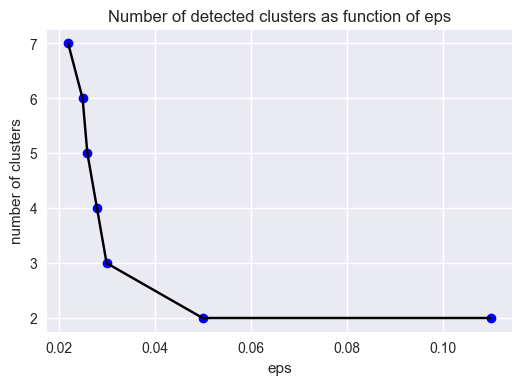

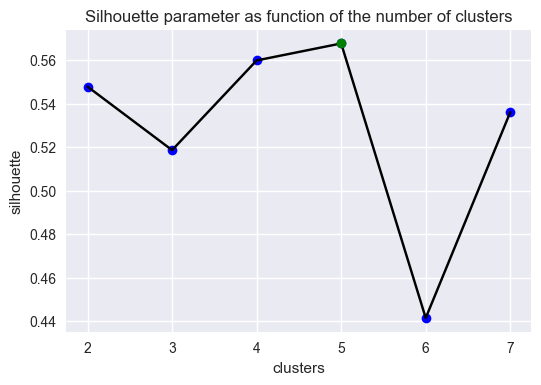

In [37]:
# cluster vs eps
eps = [0.022, 0.025, 0.026, 0.028, 0.03, 0.05, 0.11]
cls = [7, 6, 5, 4, 3, 2, 2]
plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(eps, cls, 'bo', eps, cls, 'k')
plt.xlabel('eps')
plt.ylabel('number of clusters')
plt.title('Number of detected clusters as function of eps')
plt.show()

# silhouette vs clusters
silh = [0.536025720925, 0.441402097323, 0.567620738383, 0.559807483521, 0.518574323633, 0.547765481486]
cls = [7, 6, 5, 4, 3, 2]
plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(cls, silh, 'bo', cls, silh, 'k',cls[2], silh[2], 'go')
plt.xlabel('clusters')
plt.ylabel('silhouette')
plt.title('Silhouette parameter as function of the number of clusters')
plt.show()

To sum up, **the maximum silhouette values is achieved with 5 clusters**. This is not surprising as the scatterplot $(b,c)$ of data clearly showed these 5 clusters.

**Data will be labeled with 5 clusters** and a machine learning algorithm for **multiclass classification** will be trained. 

Distribution of features for the five clusters:


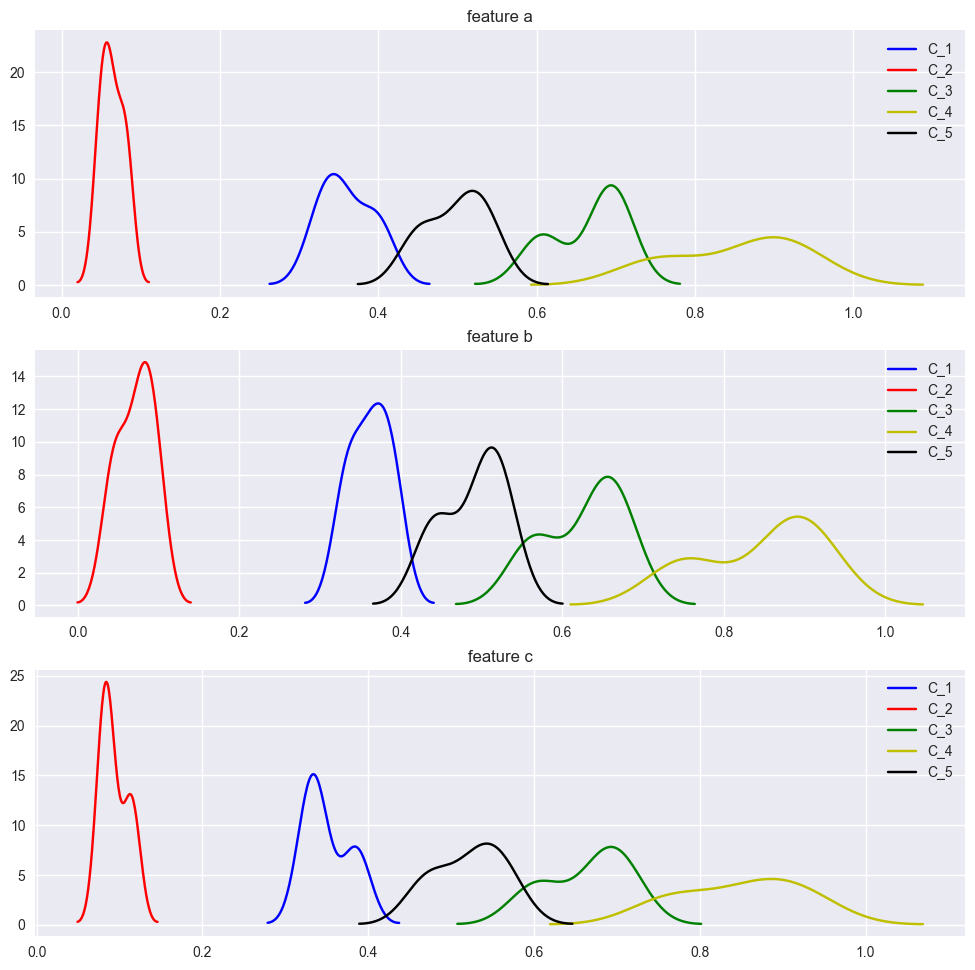

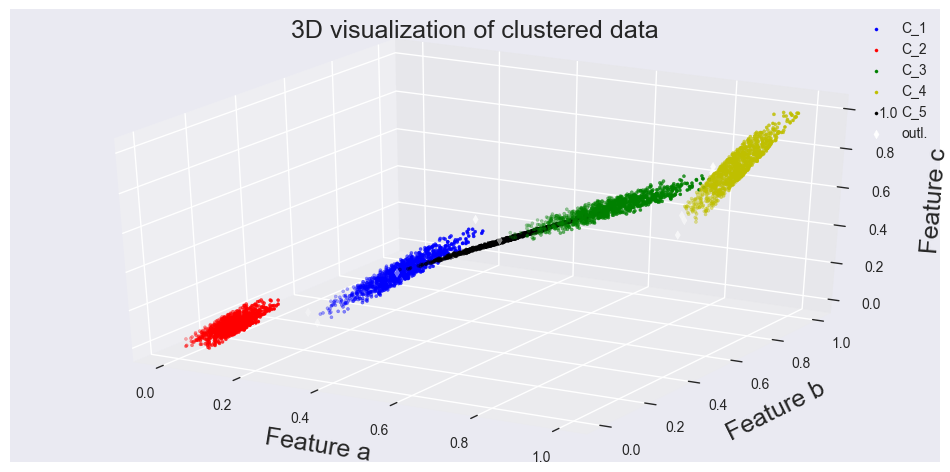

In [42]:
# Application of DBscan with eps = 0.026
db = DBSCAN(eps=0.026, 
            min_samples=5, 
            metric='euclidean', 
            algorithm='auto', 
            p=None, 
            n_jobs=1)

db.fit(dataset_scaled)
labels = db.labels_   # each element is assigned to a number according to the cluster 

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Get clusters: create a new numpy array for each cluster
C1 = dataset_scaled[np.where(labels == 0)]
C2 = dataset_scaled[np.where(labels == 1)]
C3 = dataset_scaled[np.where(labels == 2)]
C4 = dataset_scaled[np.where(labels == 3)]
C5 = dataset_scaled[np.where(labels == 4)]
outL = dataset_scaled[np.where(labels == -1)]

# compute silhouette
# Cluster: 1
N1 = np.shape(C1)[0]
data_cluster_1 = np.ones((N1,4))*0
data_cluster_1[:,:-1] = C1

# Cluster: 2
N2 = np.shape(C2)[0]
data_cluster_2 = np.ones((N2,4))*1
data_cluster_2[:,:-1] = C2

# Cluster: 3
N3 = np.shape(C3)[0]
data_cluster_3 = np.ones((N3,4))*2
data_cluster_3[:,:-1] = C3

# Cluster: 4
N4 = np.shape(C4)[0]
data_cluster_4 = np.ones((N4,4))*3
data_cluster_4[:,:-1] = C4

# Cluster: 5
N5 = np.shape(C5)[0]
data_cluster_5 = np.ones((N5,4))*4
data_cluster_5[:,:-1] = C5


# labeled dataset
dataset_labeled = np.concatenate((data_cluster_1,data_cluster_2,data_cluster_3,
                                     data_cluster_4,data_cluster_5),axis=0)



# plot distribution
print('Distribution of features for the five clusters:')
distribution_features_cluster(C1,C2,C3,C4,C5,outL)

The red cluster can be clearly distinguished as the distributions of features do not overlap with the other clusters. As regards to the remaining four clusters, distributions of features slightly overlap on the tails, but the peaks of distribution are clearly distinguished. 

## Part 3: Machine Learning model for cluster prediction

A machine learning model is now built for predicting the cluster of new data points.

We select **five clusters**, therefore we will solve a **multilabel classification problem**.


Population of each cluster


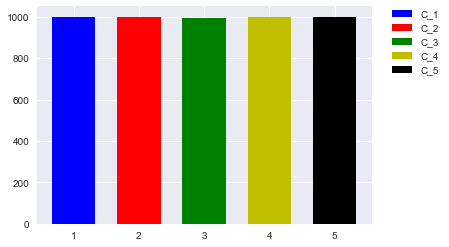

In [47]:
# Population of each cluster
print('Population of each cluster')

y = [N1, N2, N3, N4, N5]
x = [0, 1, 2, 3, 4]
width = 1/1.5

fig = plt.gcf()
plt.bar(1, N1, width, color="b", label='C_1')
plt.bar(2, N2, width, color="r", label='C_2')
plt.bar(3, N3, width, color="g", label='C_3')
plt.bar(4, N4, width, color="y", label='C_4')
plt.bar(5, N5, width, color="k", label='C_5')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



As we can see from the previous bar plot, the five clusters consist of the same amount of numbers.

In [49]:
# Split dataset into training and test
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix


Features_X = dataset_labeled[:,0:3]
Label_Y = dataset_labeled[:,3]
train_Features, test_Features, train_Label, test_Label = train_test_split(Features_X, 
                                                                            Label_Y, 
                                                                            test_size=0.2,
                                                                            random_state=42)

print(len(train_Features), "train +", len(test_Features), "test")

3991 train + 998 test


At this point, it is important to note that the label contains the numerical values 0,1,2,3,4 representing a specific cluster each. Therefore, these are categorical values and must be converted into numerical using an encoding procedure. For this tast, we use Pandas' get_dummies function.

In [50]:
train_Label_encoded = pd.get_dummies(train_Label).values
test_Label_encoded = pd.get_dummies(test_Label).values

At this point, data are ready for training a Machine Learning algorithm for multiclass classification.

- kNN classifier

- Random forest classifier

- Naive Bayes Gaussian

- Logistic regression (One vs. Rest)

Since clusters have the same number of data, we use the accuracy score.

In [66]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

kNN_clf = KNeighborsClassifier().fit(train_Features, train_Label_encoded)

Label_prediction = kNN_clf.predict(train_Features)
acc = np.mean(cross_val_score(kNN_clf, train_Features, train_Label_encoded, cv=10, scoring='accuracy'))
print('kNN classifier')
print('Average accuracy score after cross validation: ' + str(acc))


kNN classifier
Average accuracy score after cross validation: 0.99975


In [67]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

RanForest_clf = RandomForestClassifier().fit(train_Features, train_Label)

Label_prediction = RanForest_clf.predict(train_Features)

acc = np.mean(cross_val_score(RanForest_clf, train_Features, train_Label, cv=10, scoring='accuracy'))

print('Random Forest classifier')
print('Average accuracy score after cross validation: ' + str(acc))


Random Forest classifier
Average accuracy score after cross validation: 0.99649056069


In [68]:
from sklearn.naive_bayes import GaussianNB

gNB_clf = GaussianNB().fit(train_Features, train_Label)

Label_prediction = gNB_clf.predict(train_Features)

acc = np.mean(cross_val_score(gNB_clf, train_Features, train_Label, cv=10, scoring='accuracy'))

print('Naive bayes Gaussian classifier')
print('Average accuracy score after cross validation: ' + str(acc))

Naive bayes Gaussian classifier
Average accuracy score after cross validation: 0.940873977772


In [69]:
from sklearn.linear_model import LogisticRegressionCV 

LogReg_clf = LogisticRegressionCV(multi_class='ovr')   # OnevsRest approach
LogReg_clf.fit(train_Features, train_Label)

Label_prediction = LogReg_clf.predict(train_Features)

acc = np.mean(cross_val_score(LogReg_clf, train_Features, train_Label, cv=10, scoring='accuracy'))

print('Logistic Regression (One vs Rest) classifier')
print('Average accuracy score after cross validation: ' + str(acc))

Logistic Regression (One vs Rest) classifier
Average accuracy score after cross validation: 0.608871043378


kNN has highest accuracy, therefore it is the chosen algorithm for this classification task.

### Test on the test dataset

In [72]:
from sklearn.metrics import accuracy_score

Label_prediction = kNN_clf.predict(test_Features)
acc = accuracy_score(test_Label_encoded, Label_prediction) 
print('kNN classifier')
print('Average accuracy score tested with test dataset: ' + str(acc))

kNN classifier
Average accuracy score tested with test dataset: 1.0
